# Site frequency spectra of individual lineages

In [166]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns

import bct

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data

In [167]:
# Lineage dynamics data
df_expanded = pd.read_csv("data/df_expanded.filtered.csv", index_col=0)
df_persistent = pd.read_csv("data/df_persistent.filtered.csv", index_col=0)

print "Lineages"
print "Expanded", df_expanded.shape[0]
print "Persistent", df_persistent.shape[0]

Lineages
Expanded 87
Persistent 192


In [168]:
# Load frequencies of mutations for all lineages
freqs = pickle.load(open("data/SFS_Bulk_freqs.pickle"))

# Load number of leaves in each lineage
lineage_sizes = pickle.load(open("data/SFS_Bulk_lineage_sizes.pickle"))

In [169]:
# Metrics of selection
df_metrics = pd.read_csv("data/df_metrics.csv", index_col=0)
df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,D,D_pvalue_kingman
lineage_uid,,,,,,
70201010000000001,Vaccine-responsive,9166,-14.499747,0.000571,0.473259,0.043936
20201010000000001,Vaccine-responsive,15632,18.579027,1.000000,-0.914991,0.749164
20201010000000267,Vaccine-responsive,5722,17.182397,1.000000,-1.515903,0.984100
60201010000000781,Vaccine-responsive,6943,3.886945,0.999978,0.005984,0.125166
20201010000000362,Vaccine-responsive,6586,23.854739,1.000000,-0.621677,0.617446


In [170]:
# Sort lineages by metric of selection
df_metrics.sort_values(by="H_pvalue_kingman", ascending=True, inplace=True)

df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]

In [171]:
df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,D,D_pvalue_kingman
lineage_uid,,,,,,
80201010000020615,Persistent,172,-149.339861,2.309786e-08,-0.072650,0.183317
80201010000046608,Vaccine-responsive,115,-40.718383,1.663768e-05,-0.522170,0.799366
80201010000025674,Persistent,630,-31.465597,4.112562e-05,0.978020,0.042420
60201010000001694,Vaccine-responsive,5000,-28.294370,4.301773e-05,1.314972,0.010944
70201010000017403,Vaccine-responsive,212,-25.576142,8.204181e-05,-0.532884,0.507059


# Calculate SFS for individual lineages

In [172]:
import bct

In [173]:
# Choose bins for SFS
bins = np.array([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999])
bin_centers_manual = np.array([5e-5, 5e-4, 5e-3, 5e-2, 0.25, 0.75, 1-5e-2, 1-5e-3, 1-5e-4, 1-5e-5])
bin_centers = np.sqrt(bins[1:] * bins[:-1])

In [174]:
# Compute SFS for every lineage in an ensemble

def calc_sfs_ensemble(freqs, lineage_sizes, lineage_uids, bins):
    """ Calculate mean SFS over an ensemble by taking mean value at each bin """
    S = np.empty((len(lineage_uids), len(bins)-1))
    for i, lineage_uid in enumerate(lineage_uids):
        myFreqs = freqs[lineage_uid].values()
        myLeaves = lineage_sizes[lineage_uid]
        binned_sfs, binned_sfs_normed = bct.bin_sfs_cut(myFreqs, bins=bins, leaves=myLeaves)
        S[i,:] = binned_sfs_normed
    return S

# Calculate SFS
S_expanded = calc_sfs_ensemble(freqs, lineage_sizes, list(df_metrics_expanded.index), bins)
S_persistent = calc_sfs_ensemble(freqs, lineage_sizes, list(df_metrics_persistent.index), bins)

# Plot SFSs of individual lineages as heatmaps with metrics aligned

In [175]:
# Define function to plot SFS as heatmap
def plot_sfs_ensemble(ax, S, bin_centers, cmap_name, **kwargs):
    from matplotlib.colors import LogNorm
    S_pseudocount = S + 1e-2
    S_masked = np.ma.array(S_pseudocount, mask=np.isnan(S_pseudocount))
    cmap = mpl.cm.get_cmap(cmap_name)
    cmap.set_bad('gray', 1.0)
    ax.imshow(S_masked, norm=LogNorm(vmin=1e-2, vmax=1e6),
              interpolation='none', cmap=cmap, **kwargs)
    # ax.set_adjustable('box-forced')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

# Vaccine-responsive lineages

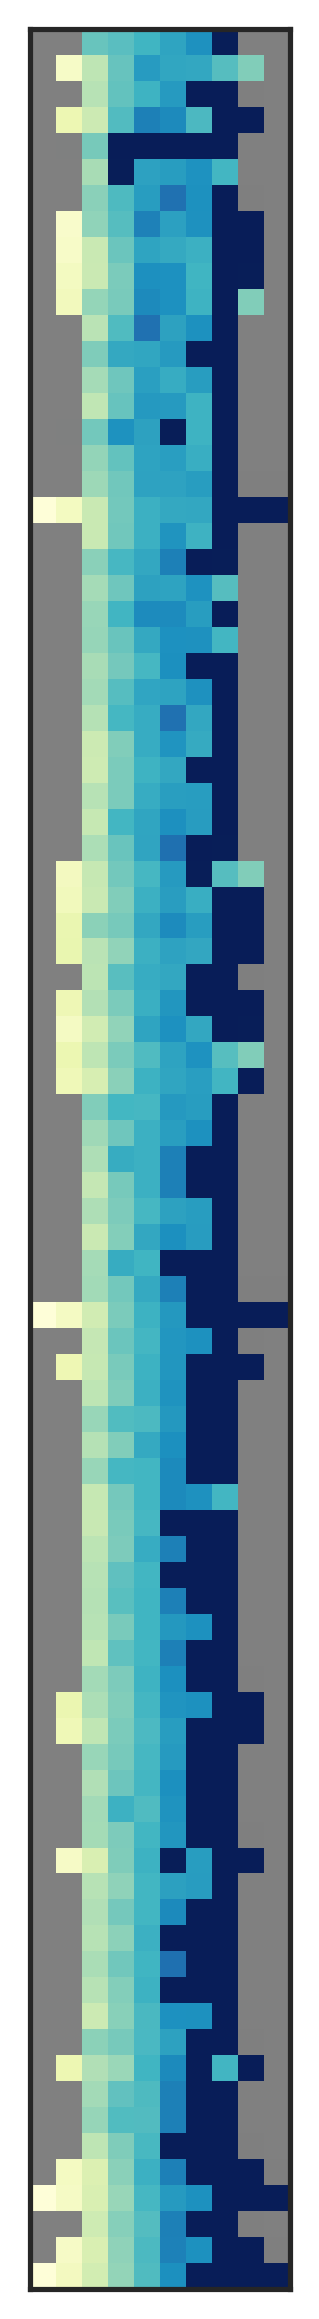

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(4,8))
plot_sfs_ensemble(ax, S_expanded[::-1], bin_centers, cmap_name="YlGnBu_r")
ax.set_ylim(-0.5, df_metrics_expanded.shape[0]-0.5)
plt.tight_layout()
save_figure(fig, "SFS_Heatmaps_expanded", output_dir, output_suffix, output_formats, savefig_args)

In [177]:
# Define function for plotting colorbar (cbar is separate and we place it into the final figure)
def plot_sfs_ensemble_cbar(ax, S, bin_centers, cmap_name, **kwargs):
    
    from matplotlib.colors import LogNorm
    S_pseudocount = S + 1e-2
    S_masked = np.ma.array(S_pseudocount, mask=np.isnan(S_pseudocount))
    cmap = mpl.cm.get_cmap(cmap_name)
    cmap.set_bad('gray', 1.0)
    im = ax.imshow(S_masked, norm=LogNorm(vmin=1e-2, vmax=1e6),
              interpolation='none', cmap=cmap, **kwargs)
    cbar = fig.colorbar(im, ticks=[1e6, 1e4, 1e2, 1e0, 1e-2], orientation='horizontal')
    cbar.set_ticklabels([r'$10^{6}$', r'$10^{4}$', r'$10^{2}$', r'$1$', 0])
    # ax.set_adjustable('box-forced')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    return ax

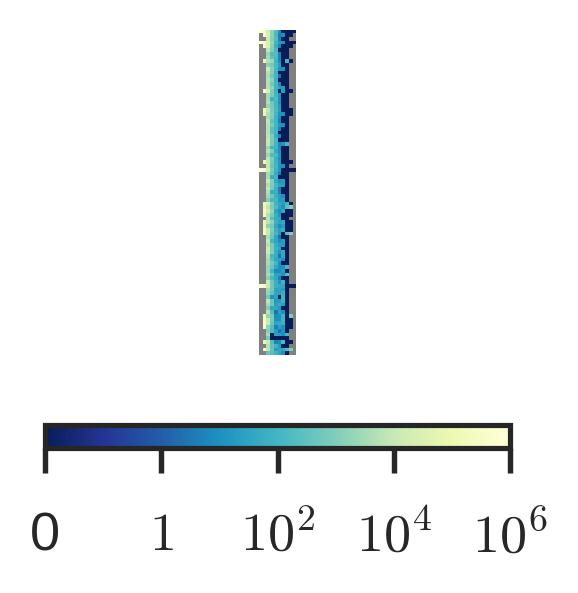

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
plot_sfs_ensemble_cbar(ax, S_expanded[::-1], bin_centers, cmap_name="YlGnBu_r")
save_figure(fig, "SFS_Heatmaps_expanded_cbar", output_dir, output_suffix, output_formats, savefig_args)

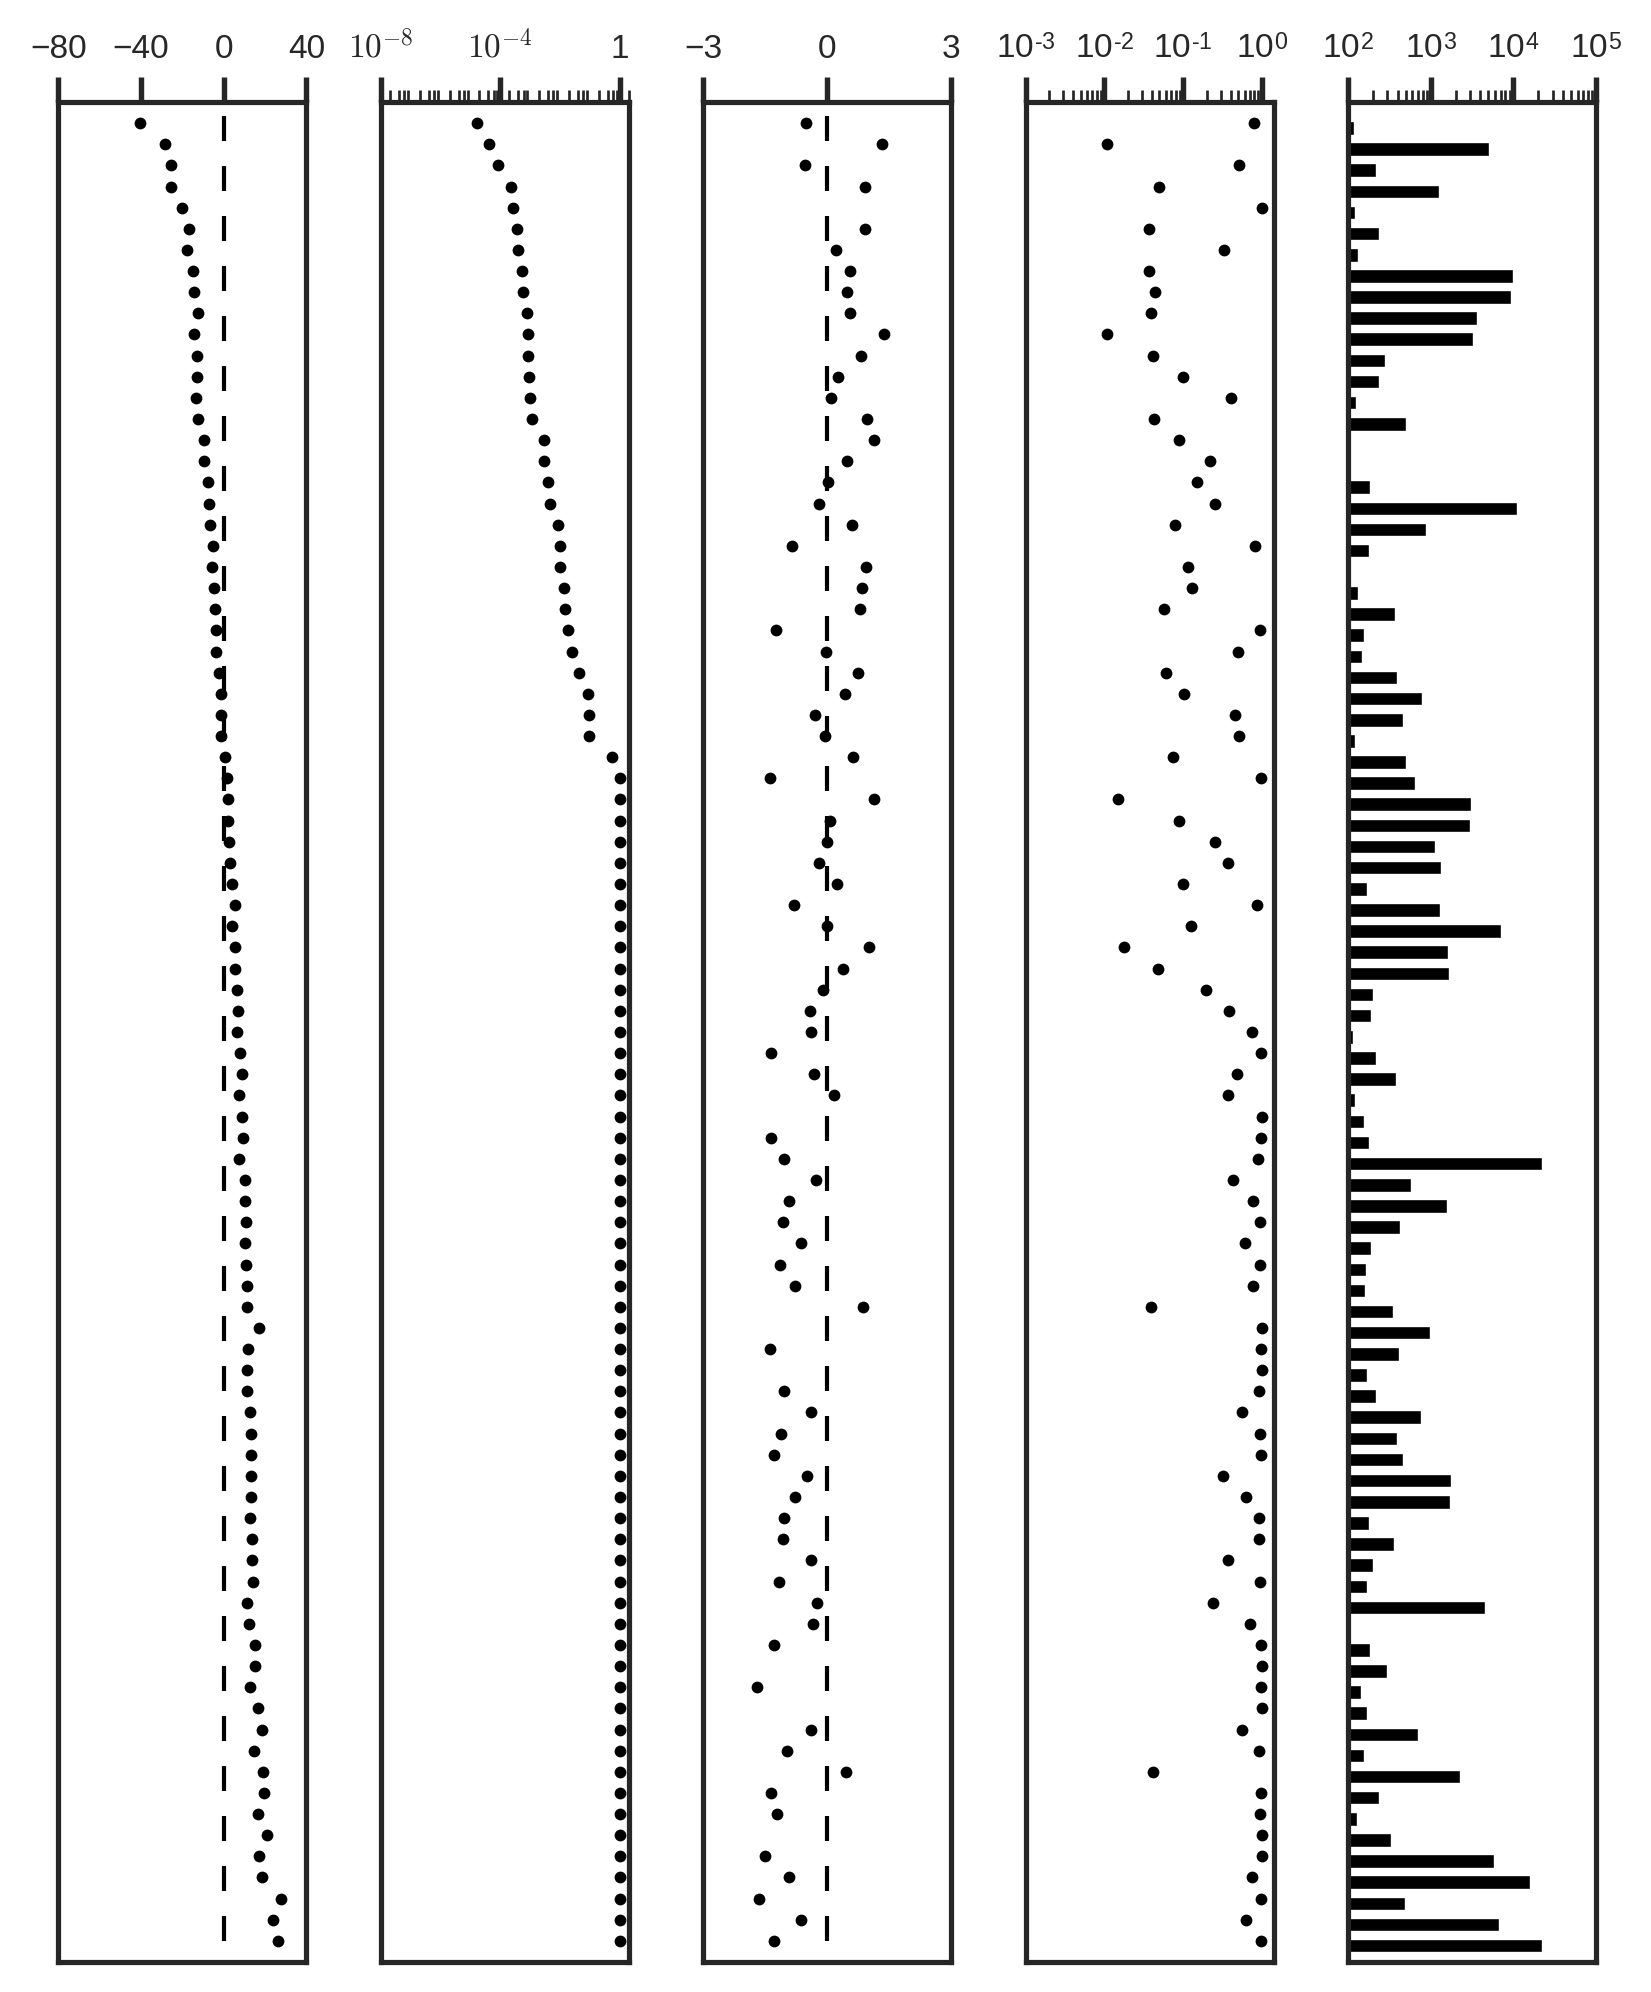

In [179]:
# Plot metrics aligned with heatmap

from matplotlib import gridspec
from matplotlib.colors import LogNorm

mpl.rcParams.update({'font.size': 22})
cmap_scatter = "RdYlBu"

fig = plt.figure(figsize=(8,8)) 
gs = gridspec.GridSpec(1, 6)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)
ax3 = fig.add_subplot(gs[0,3], sharey=ax0)
ax4 = fig.add_subplot(gs[0,4], sharey=ax0)
# ax5 = fig.add_subplot(gs[0,5], sharey=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]
# axes_cbars = [ax0_cbar, ax1_cbar, ax2_cbar, ax3_cbar]

y = range(0,df_metrics_expanded.shape[0])[::-1]
s = 8

ax = ax0
x = df_metrics_expanded["H"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[40, 0, -40, -80]
ax.set_xticks(ticks)

ax = ax1
# x = np.log10(df_metrics_expanded["pvalue_kingman"])
x = df_metrics_expanded["H_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-7, 2)
ax.set_xscale('log')
ticks=[1e-8, 1e-4, 1]
ax.set_xticks(ticks)
ticklabels=[r'$10^{-8}$', r'$10^{-4}$', 1]
ax.set_xticklabels(ticklabels)

ax = ax2
x = df_metrics_expanded["D"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[-3, 0, 3]
ax.set_xticks(ticks)

ax = ax3
# x = np.log10(df_metrics_expanded["D_pvalue_kingman"])
x = df_metrics_expanded["D_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-3, 1.4)
ax.set_xscale("log")
# ticks=[-2, -1, 0]
# ax.set_xticks(ticks)

ax = ax4
x = df_metrics_expanded['num_seq']
sc = ax.barh(np.array(y)-0.5, x, 0.5, color="k")
ax.set_xscale("log")
ticks=[1e2, 1e3, 1e4, 1e5]
ax.set_xticks(ticks)

for ax in axes:
    ax.set_ylim(-1, df_metrics_expanded.shape[0])
    ax.tick_params(labelsize=8, pad=1)
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.xaxis.tick_top()
    # sns.despine()
    
plt.subplots_adjust(wspace=0.3)

save_figure(fig, "SFS_Heatmaps_metrics_expanded", output_dir, output_suffix, output_formats, savefig_args)

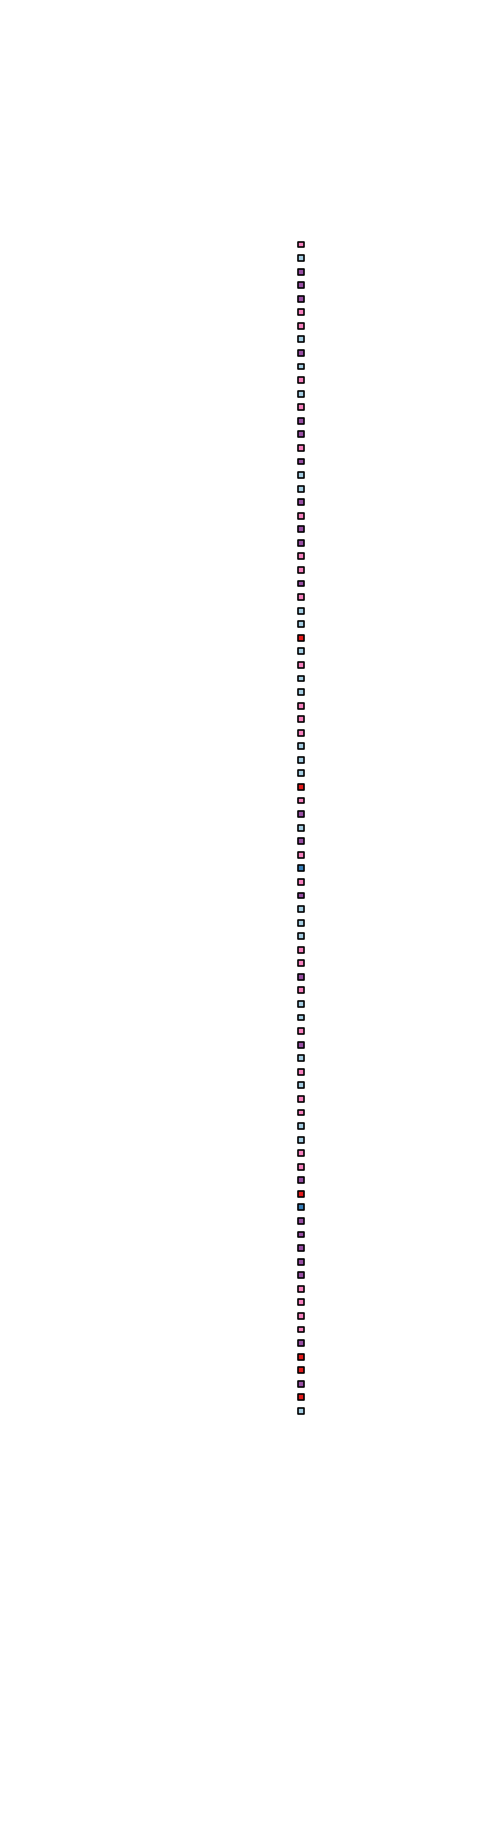

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(1,7))
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_color = dict(zip([2,3,6,7,8],myColors_subjects))
c = np.array([patient_uid_to_color[int(str(x)[0])] for x in list(df_metrics_expanded.index)])
x = [0] * len(c)
ax.scatter(x, y, c=c, marker="s", s=2)
ax.set_xlim(-1,1)
ax.axis('off')
save_figure(fig, "SFS_Heatmaps_subjects_expanded", output_dir, output_suffix, output_formats, savefig_args)

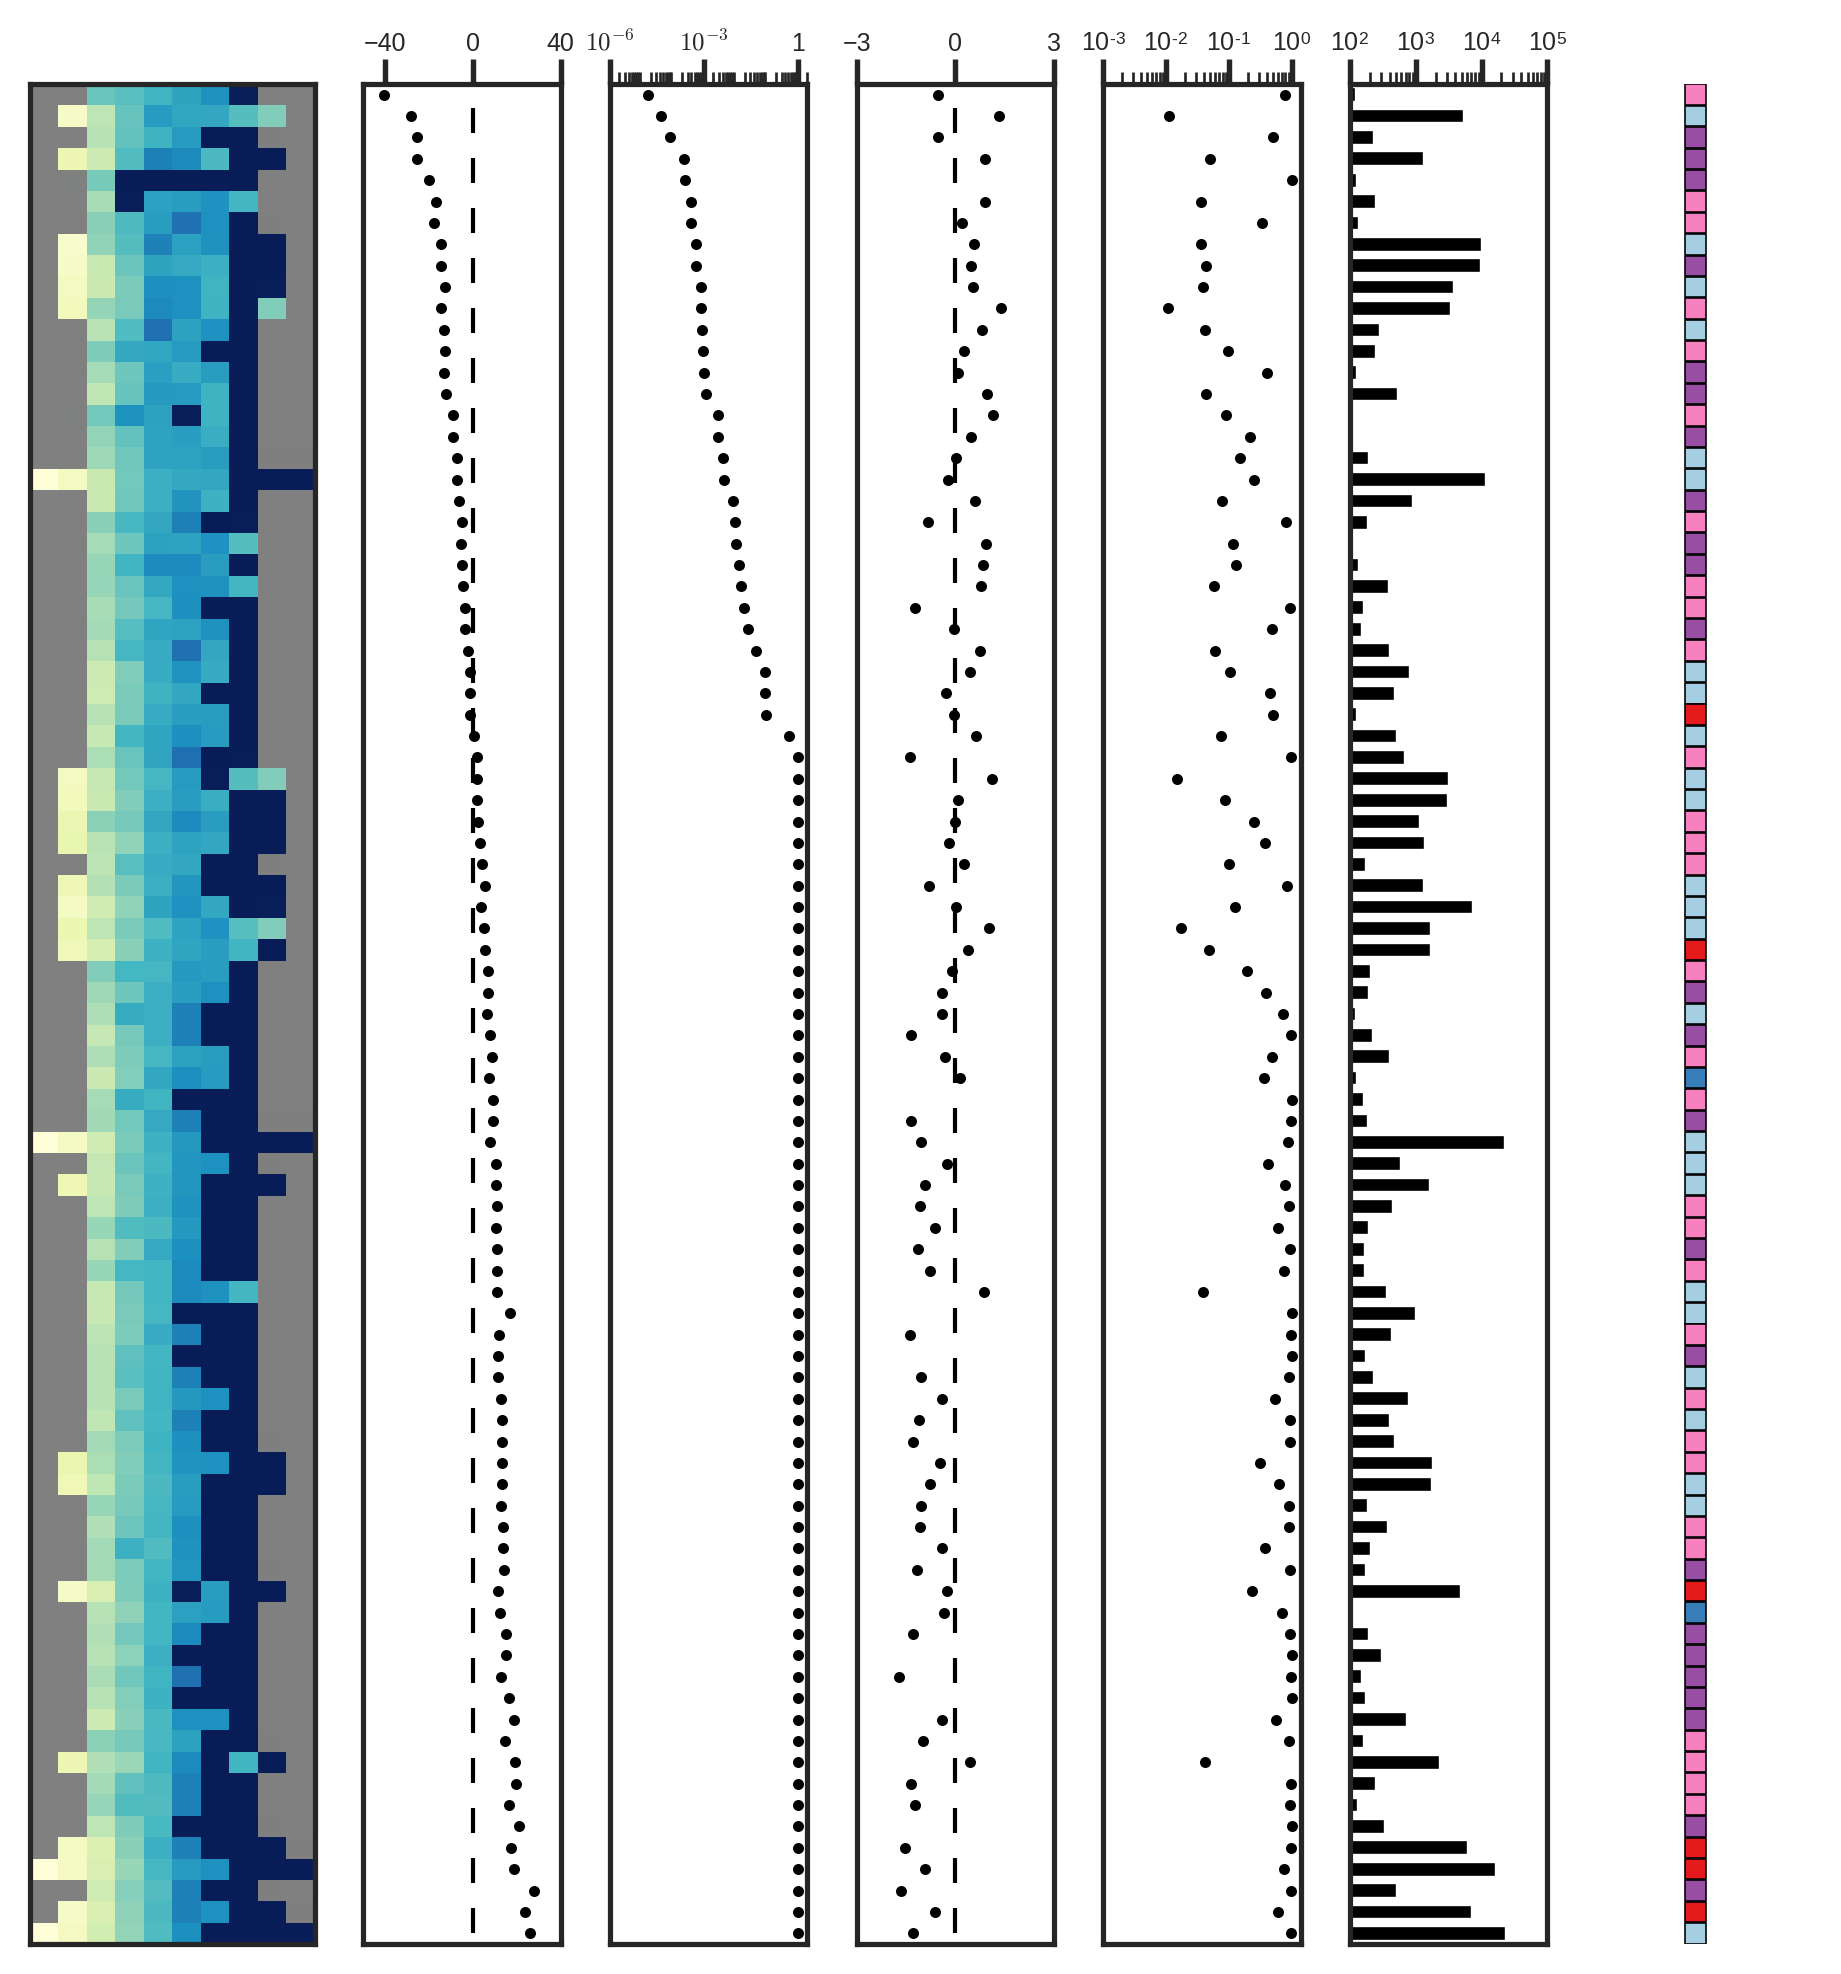

In [202]:
# Plot everything together

from matplotlib import gridspec
from matplotlib.colors import LogNorm

mpl.rcParams.update({'font.size': 22})
cmap_scatter = "RdYlBu"

fig = plt.figure(figsize=(8,8))

outer = gridspec.GridSpec(1, 2, width_ratios=[2, 6], wspace=-0.05)
gs = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec = outer[1], wspace = 0.25)

ax0 = fig.add_subplot(outer[0,0])
ax1 = fig.add_subplot(gs[0,0], sharey=ax0)
ax2 = fig.add_subplot(gs[0,1], sharey=ax0)
ax3 = fig.add_subplot(gs[0,2], sharey=ax0)
ax4 = fig.add_subplot(gs[0,3], sharey=ax0)
ax5 = fig.add_subplot(gs[0,4], sharey=ax0)
ax6 = fig.add_subplot(gs[0,5], sharey=ax0)
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

y = range(0,df_metrics_expanded.shape[0])[::-1]
s = 7

ax = ax0
plot_sfs_ensemble(ax, S_expanded[::-1], bin_centers, cmap_name="YlGnBu_r")
ax.set_ylim(-0.5, df_metrics_expanded.shape[0]-0.5)
ax.set_aspect(0.75)
ax.set_adjustable('box-forced')

ax = ax1
x = df_metrics_expanded["H"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[40, 0, -40]
ax.set_xticks(ticks)

ax = ax2
# x = np.log10(df_metrics_expanded["pvalue_kingman"])
x = df_metrics_expanded["H_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-6, 2)
ax.set_xscale('log')
ticks=[1e-6, 1e-3, 1]
ax.set_xticks(ticks)
ticklabels=[r'$10^{-6}$', r'$10^{-3}$', 1]
ax.set_xticklabels(ticklabels)

ax = ax3
x = df_metrics_expanded["D"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[-3, 0, 3]
ax.set_xticks(ticks)

ax = ax4
# x = np.log10(df_metrics_expanded["D_pvalue_kingman"])
x = df_metrics_expanded["D_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-3, 1.4)
ax.set_xscale("log")
# ticks=[-2, -1, 0]
# ax.set_xticks(ticks)

ax = ax5
x = df_metrics_expanded['num_seq']
sc = ax.barh(np.array(y)-0.25, x, 0.5, color="k")
ax.set_xscale("log")
ticks=[1e2, 1e3, 1e4, 1e5]
ax.set_xticks(ticks)

ax = ax6
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_color = dict(zip([2,3,6,7,8],myColors_subjects))
c = np.array([patient_uid_to_color[int(str(x)[0])] for x in list(df_metrics_expanded.index)])
x = [0] * len(c)
ax.scatter(x, y, c=c, marker="s", s=24)
ax.set_xlim(-1,1)
ax.axis('off')

for ax in axes[1:]:
    ax.set_ylim(-0.5, df_metrics_expanded.shape[0]-0.5)
    ax.tick_params(labelsize=6, pad=1)
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.xaxis.tick_top()

save_figure(fig, "SFS_Heatmaps_SFSWithMetricsSubjects_expanded", output_dir, output_suffix, output_formats, savefig_args)

In [182]:
# Print summaries of lineages
pvalue_cutoff = 0.05

print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H"
print sum(df_metrics_expanded["H_pvalue_kingman"] < pvalue_cutoff) / float(df_metrics_expanded["H_pvalue_kingman"].shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by non-monotonicity D"
print sum(df_metrics_expanded["D_pvalue_kingman"] < pvalue_cutoff) / float(df_metrics_expanded["D_pvalue_kingman"].shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H AND D"
print sum((df_metrics_expanded["H_pvalue_kingman"] < pvalue_cutoff) & (df_metrics_expanded["D_pvalue_kingman"] < 0.05)) / float(df_metrics_expanded.shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H OR D"
print sum((df_metrics_expanded["H_pvalue_kingman"] < pvalue_cutoff) | (df_metrics_expanded["D_pvalue_kingman"] < 0.05)) / float(df_metrics_expanded.shape[0])


Fraction of lineages with significant deviation from neutrality by Fay and Wu's H
0.310344827586

Fraction of lineages with significant deviation from neutrality by non-monotonicity D
0.16091954023

Fraction of lineages with significant deviation from neutrality by Fay and Wu's H AND D
0.103448275862

Fraction of lineages with significant deviation from neutrality by Fay and Wu's H OR D
0.367816091954


# Persistent lineages

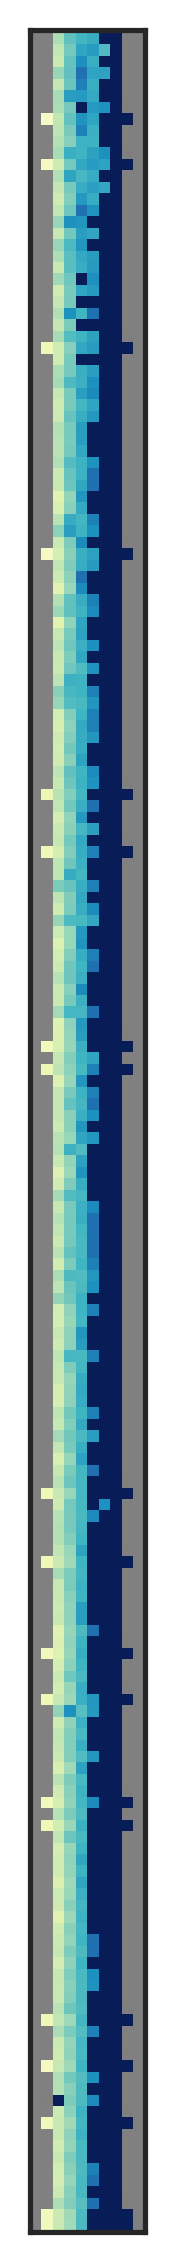

In [183]:
# Heatmaps
fig, ax = plt.subplots(1, 1, figsize=(4,8))
plot_sfs_ensemble(ax, S_persistent[::-1], bin_centers, cmap_name="YlGnBu_r")
ax.set_ylim(-0.5, df_metrics_persistent.shape[0]-0.25)
plt.tight_layout()
save_figure(fig, "SFS_Heatmaps_persistent", output_dir, output_suffix, output_formats, savefig_args)

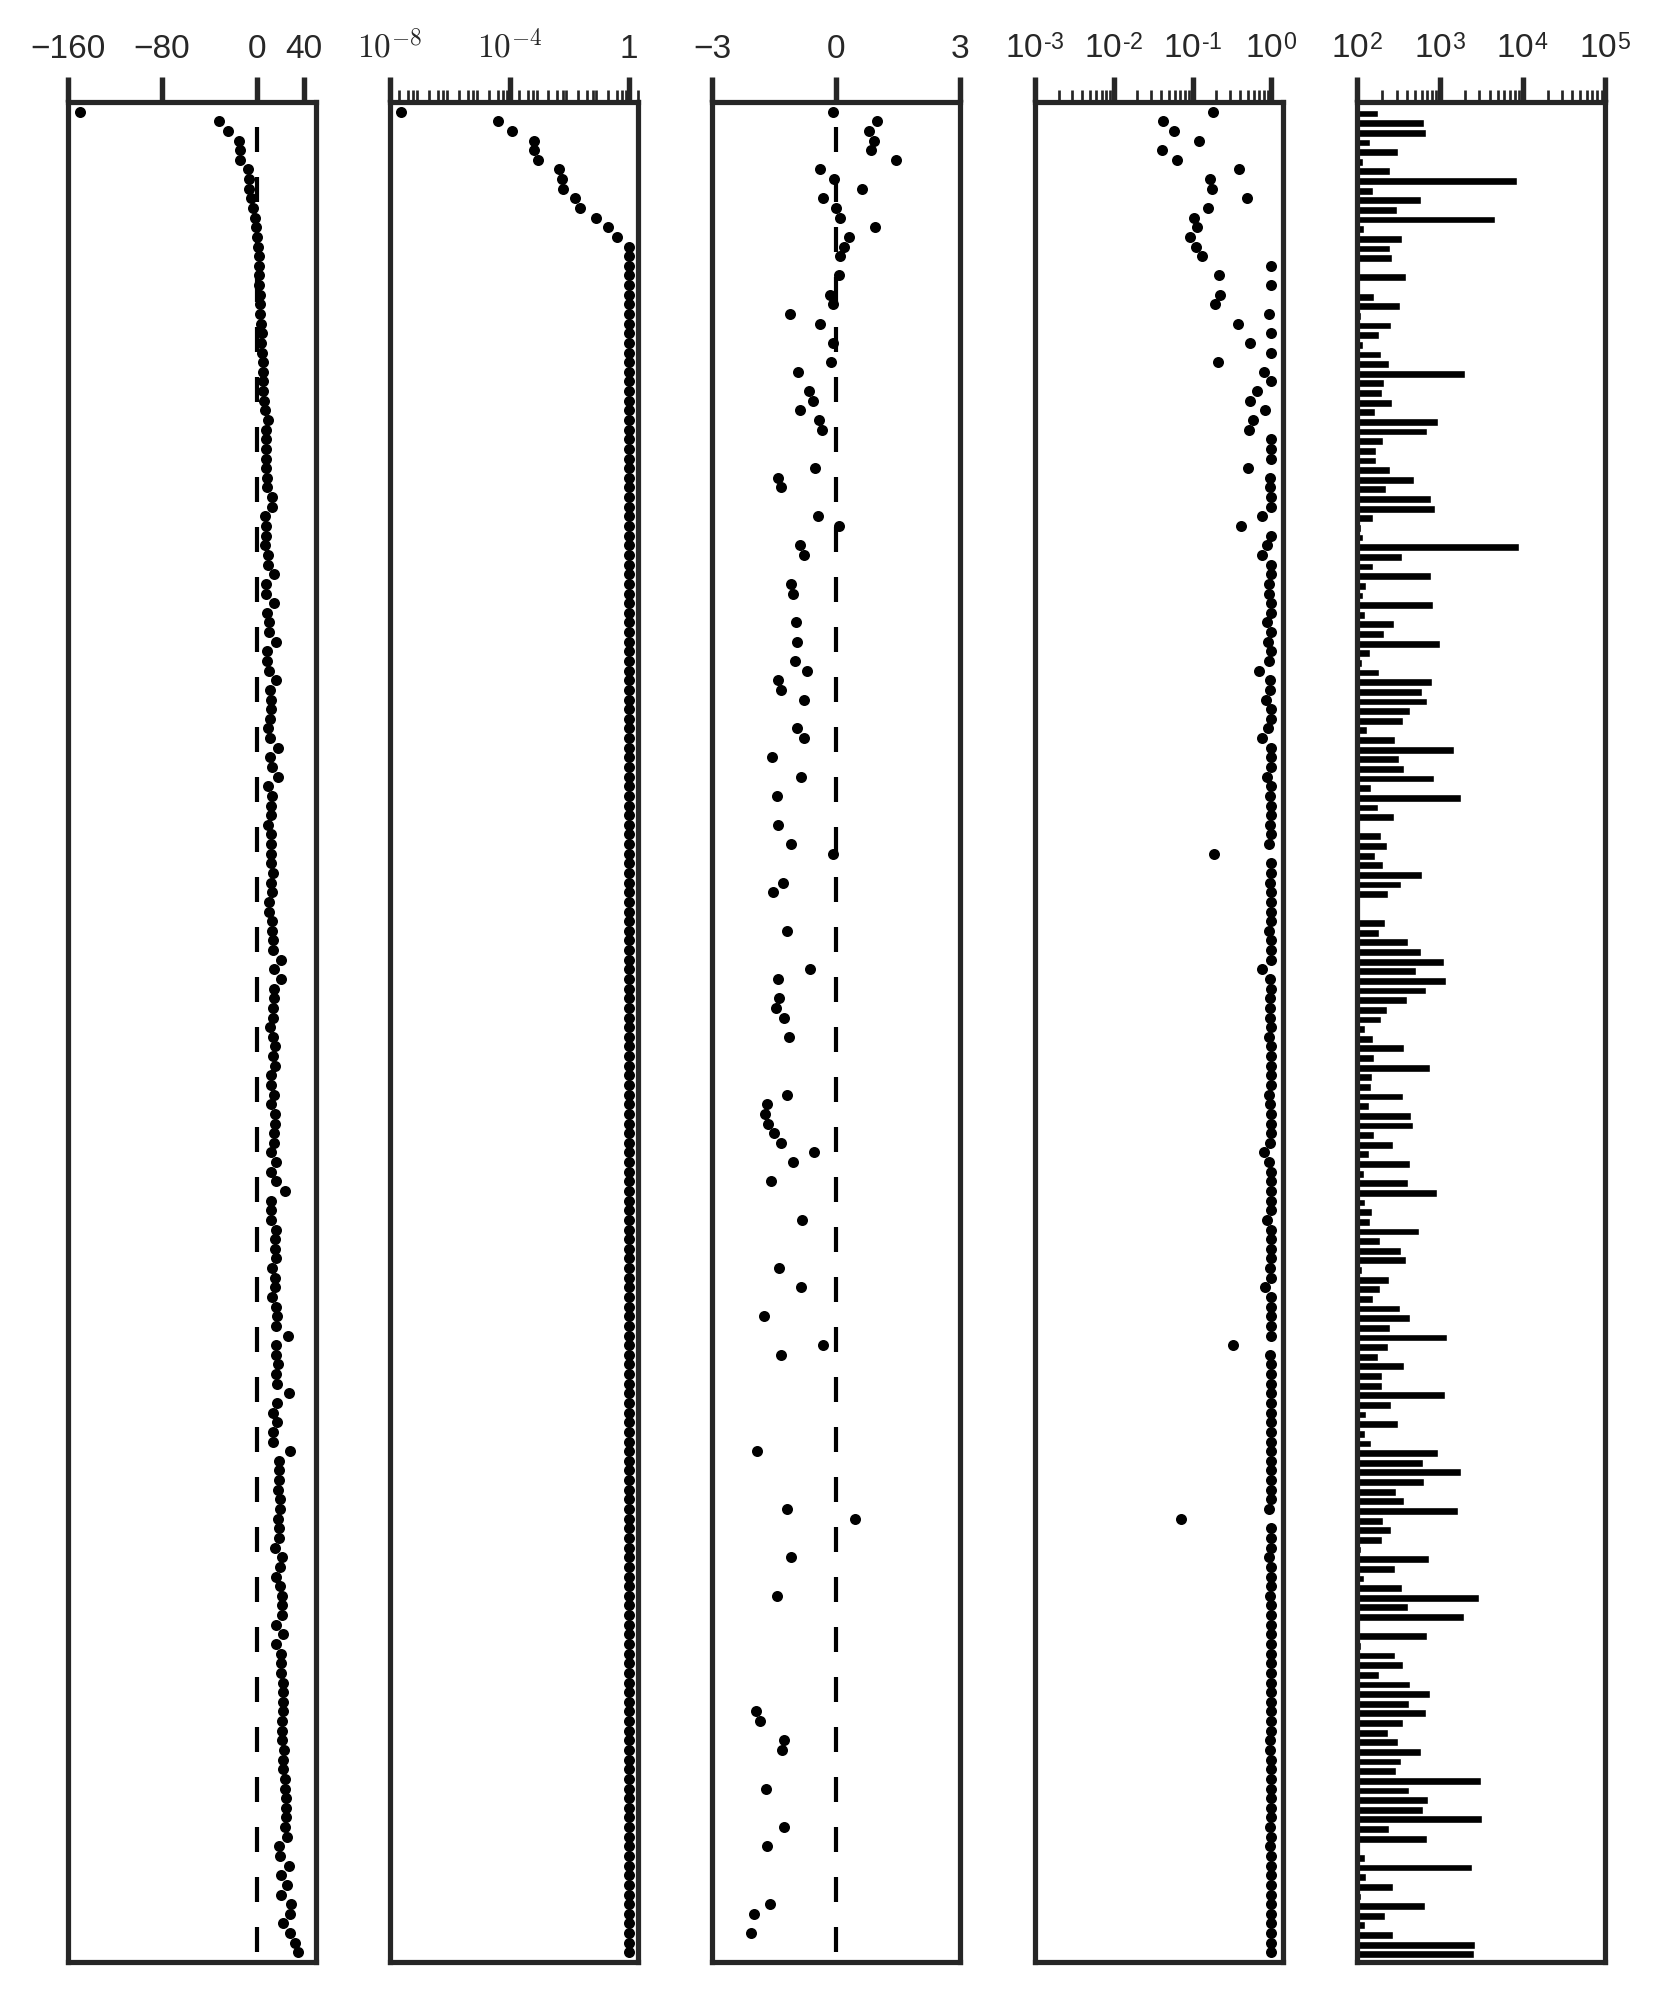

In [184]:
# Plot metrics aligned with heatmap

from matplotlib import gridspec
from matplotlib.colors import LogNorm

mpl.rcParams.update({'font.size': 22})
cmap_scatter = "RdYlBu"

fig = plt.figure(figsize=(8,8)) 
gs = gridspec.GridSpec(1, 6)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)
ax3 = fig.add_subplot(gs[0,3], sharey=ax0)
ax4 = fig.add_subplot(gs[0,4], sharey=ax0)
# ax5 = fig.add_subplot(gs[0,5], sharey=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]
# axes_cbars = [ax0_cbar, ax1_cbar, ax2_cbar, ax3_cbar]

y = range(0,df_metrics_persistent.shape[0])[::-1]
s = 7

ax = ax0
x = df_metrics_persistent["H"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ax.set_xlim(left=-160)
ticks=[40, 0, -80, -160]
ax.set_xticks(ticks)

ax = ax1
# x = np.log10(df_metrics_persistent["pvalue_kingman"])
x = df_metrics_persistent["H_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-8, 2)
ax.set_xscale('log')
ticks=[1e-8, 1e-4, 1]
ax.set_xticks(ticks)
ticklabels=[r'$10^{-8}$', r'$10^{-4}$', 1]
ax.set_xticklabels(ticklabels)

ax = ax2
x = df_metrics_persistent["D"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[-3, 0, 3]
ax.set_xticks(ticks)

ax = ax3
# x = np.log10(df_metrics_persistent["D_pvalue_kingman"])
x = df_metrics_persistent["D_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-3, 1.4)
ax.set_xscale("log")
# ticks=[-2, -1, 0]
# ax.set_xticks(ticks)

ax = ax4
x = df_metrics_persistent['num_seq']
sc = ax.barh(np.array(y)-0.5, x, 0.5, color="k")
ax.set_xscale("log")
ticks=[1e2, 1e3, 1e4, 1e5]
ax.set_xticks(ticks)

for ax in axes:
    ax.set_ylim(-1, df_metrics_persistent.shape[0])
    ax.tick_params(labelsize=8, pad=1)
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.xaxis.tick_top()
    # sns.despine()
    
plt.subplots_adjust(wspace=0.3)

save_figure(fig, "SFS_Heatmaps_metrics_persistent", output_dir, output_suffix, output_formats, savefig_args)

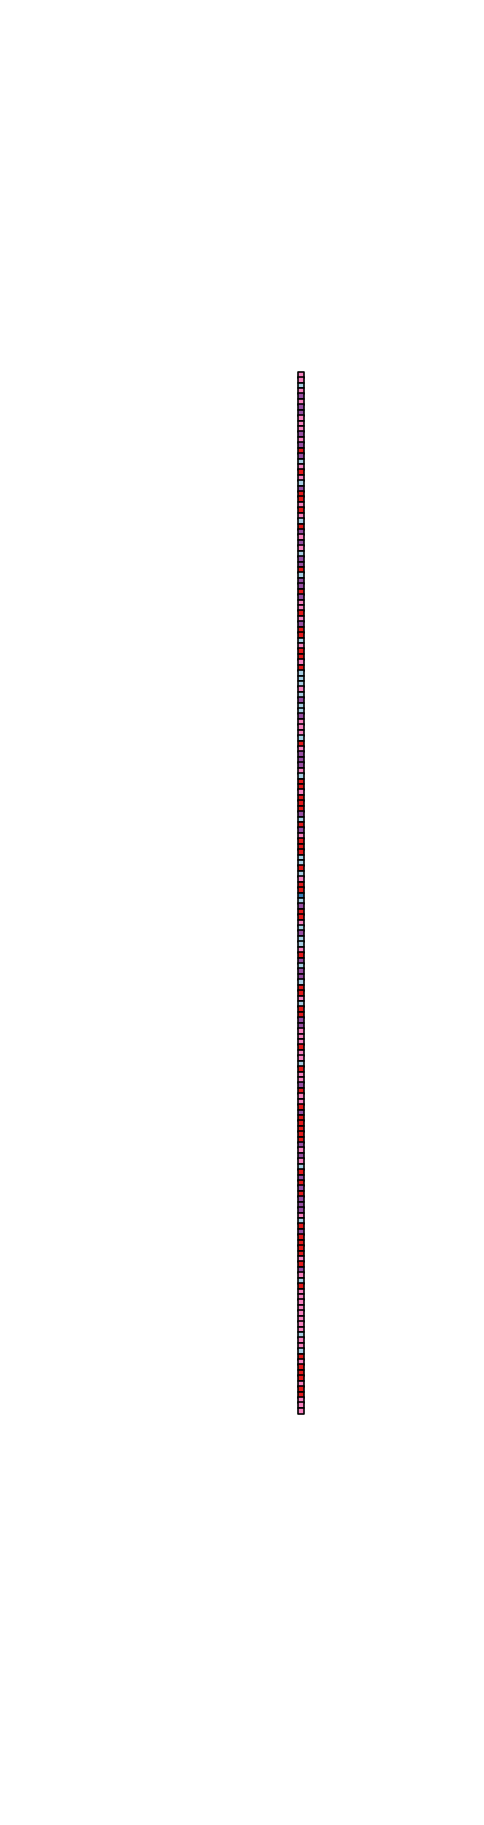

In [185]:
# Subjects
fig, ax = plt.subplots(1, 1, figsize=(1,7))
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_color = dict(zip([2,3,6,7,8],myColors_subjects))
c = np.array([patient_uid_to_color[int(str(x)[0])] for x in list(df_metrics_persistent.index)])
x = [0] * len(c)
ax.scatter(x, y, c=c, marker="s", s=2)
ax.set_xlim(-1,1)
ax.axis('off')
save_figure(fig, "SFS_Heatmaps_subjects_persistent", output_dir, output_suffix, output_formats, savefig_args)

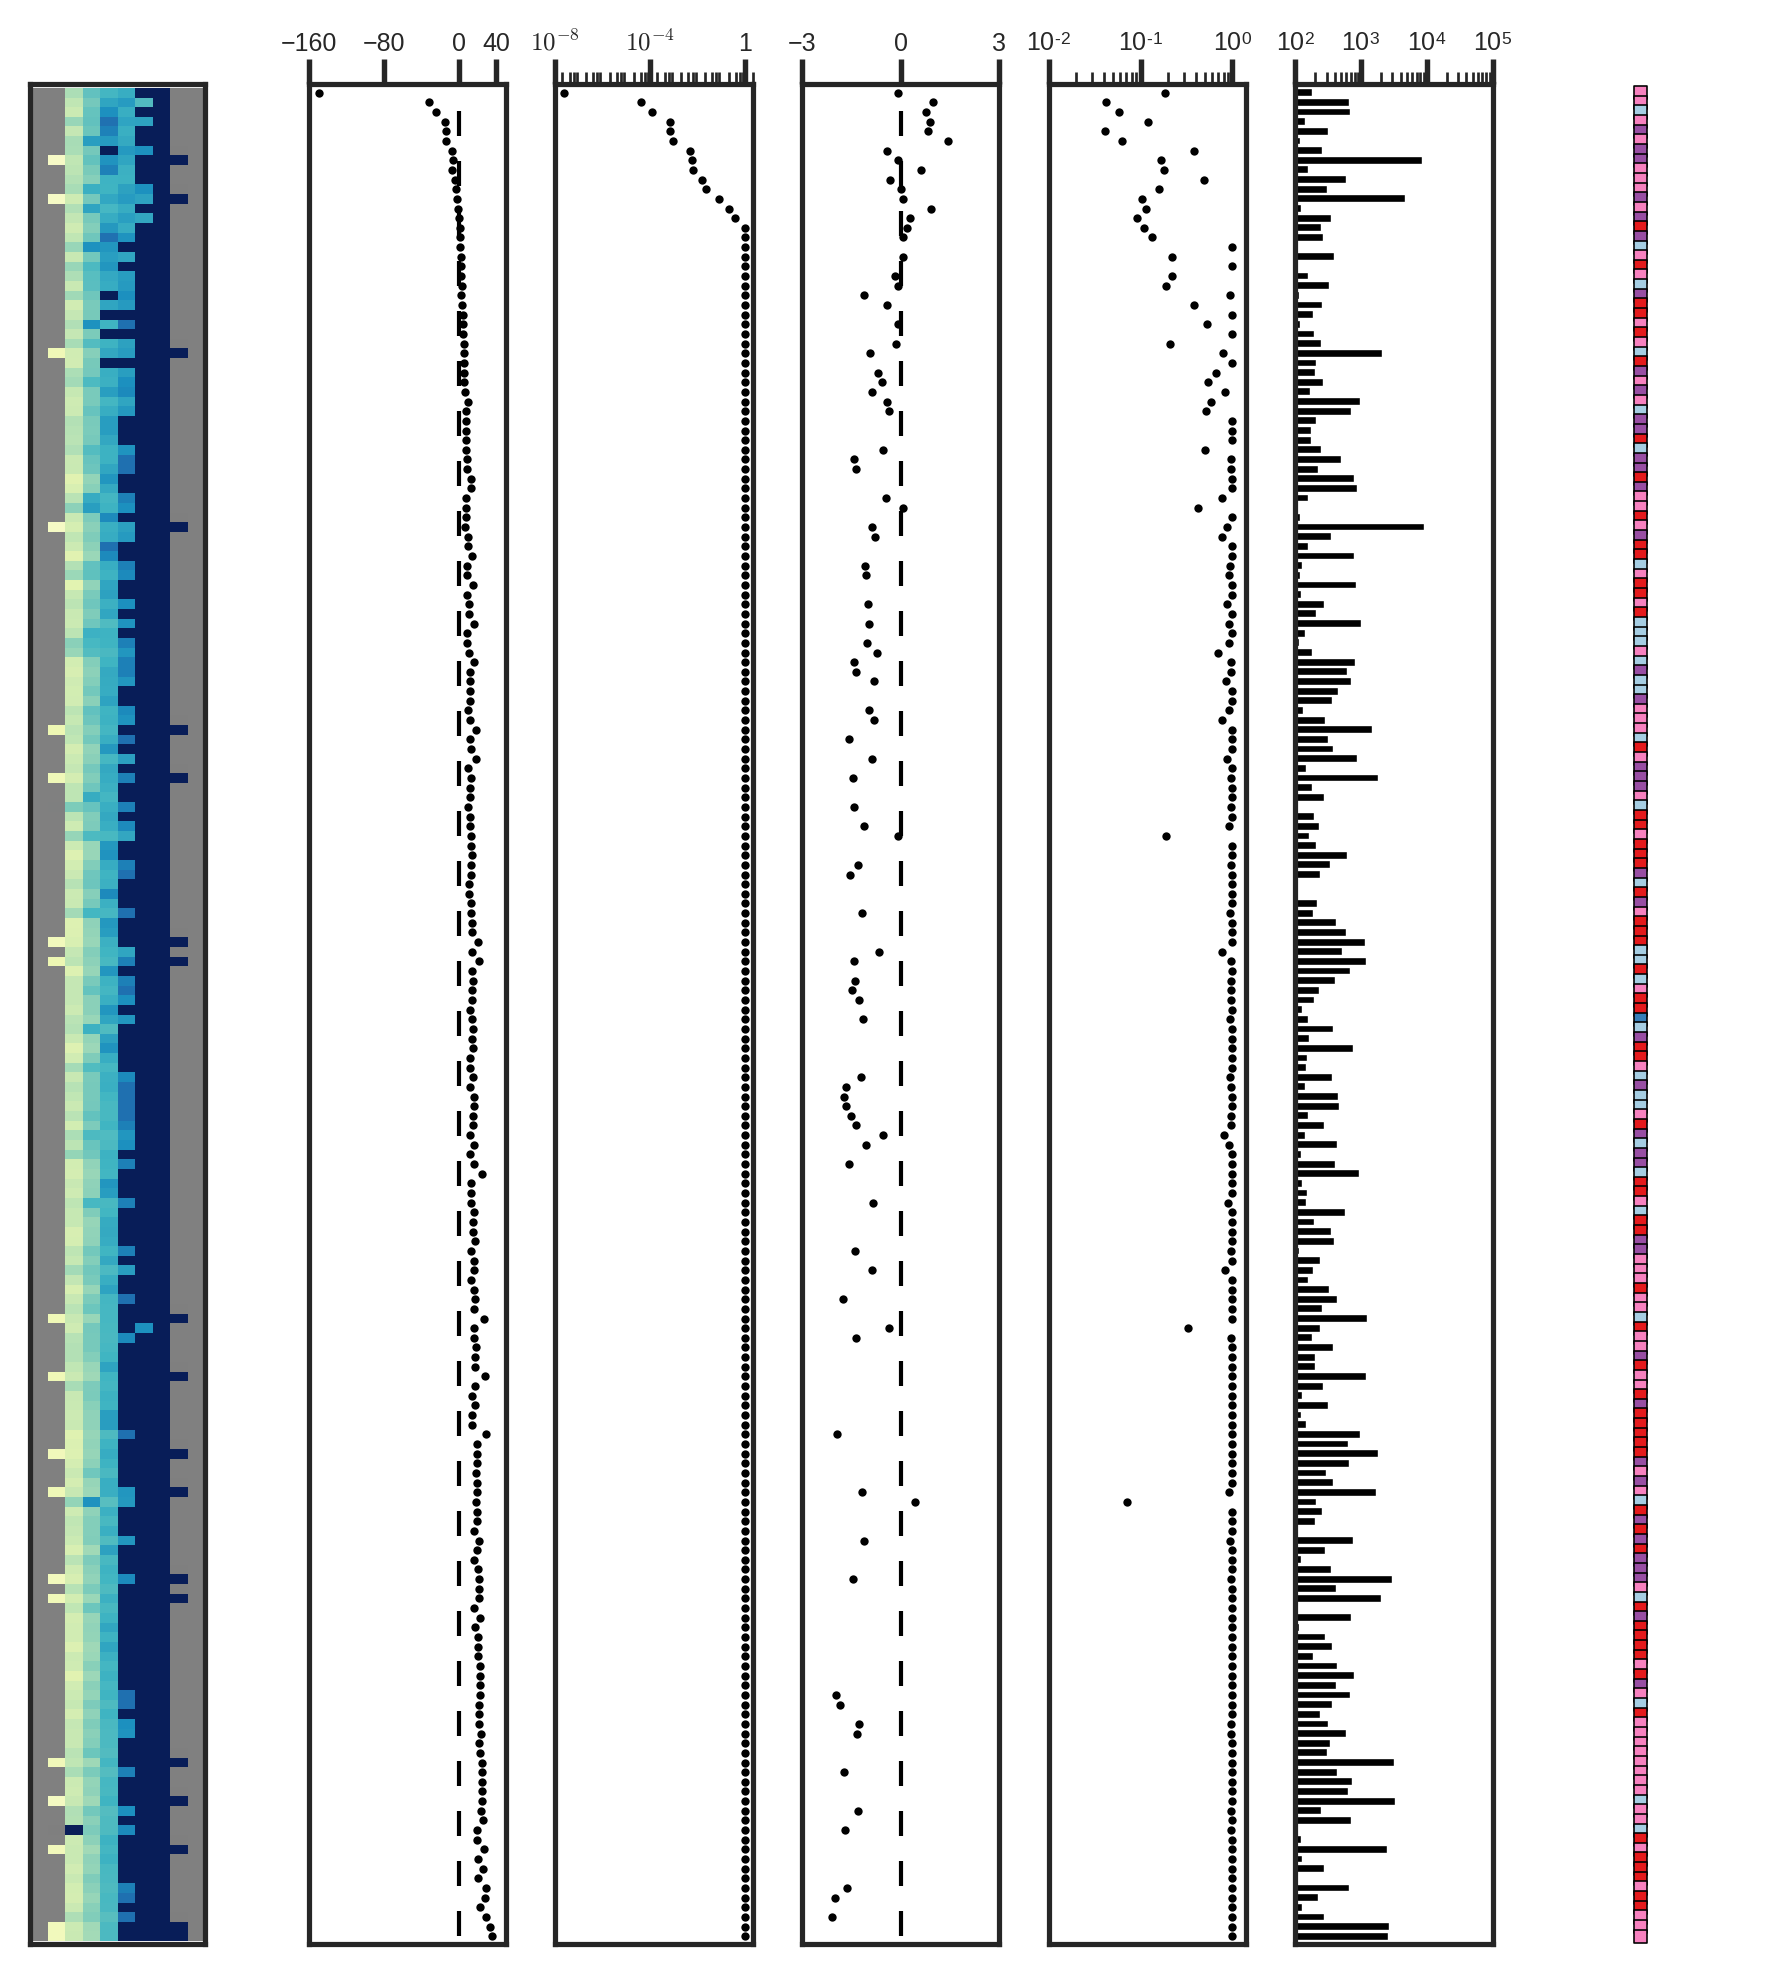

In [203]:
# Plot everything together

from matplotlib import gridspec
from matplotlib.colors import LogNorm

mpl.rcParams.update({'font.size': 22})
cmap_scatter = "RdYlBu"

fig = plt.figure(figsize=(8,8))

outer = gridspec.GridSpec(1, 2, width_ratios=[2, 6], wspace=-0.05)
gs = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec = outer[1], wspace = 0.25)

ax0 = fig.add_subplot(outer[0,0])
ax1 = fig.add_subplot(gs[0,0], sharey=ax0)
ax2 = fig.add_subplot(gs[0,1], sharey=ax0)
ax3 = fig.add_subplot(gs[0,2], sharey=ax0)
ax4 = fig.add_subplot(gs[0,3], sharey=ax0)
ax5 = fig.add_subplot(gs[0,4], sharey=ax0)
ax6 = fig.add_subplot(gs[0,5], sharey=ax0)
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

y = range(0,df_metrics_persistent.shape[0])[::-1]
s = 4

ax = ax0
plot_sfs_ensemble(ax, S_persistent[::-1], bin_centers, cmap_name="YlGnBu_r")
ax.set_ylim(-0.5, df_metrics_persistent.shape[0]-0.5)
ax.set_aspect(0.55)
ax.set_adjustable('box-forced')

ax = ax1
x = df_metrics_persistent["H"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ax.set_xlim(left=-160)
ticks=[40, 0, -80, -160]
ax.set_xticks(ticks)

ax = ax2
# x = np.log10(df_metrics_persistent["pvalue_kingman"])
x = df_metrics_persistent["H_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-7, 2)
ax.set_xscale('log')
ticks=[1e-8, 1e-4, 1]
ax.set_xticks(ticks)
ticklabels=[r'$10^{-8}$', r'$10^{-4}$', 1]
ax.set_xticklabels(ticklabels)

ax = ax3
x = df_metrics_persistent["D"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.plot((0,0),(min(y),max(y)+10), "k--", lw=1)
ticks=[-3, 0, 3]
ax.set_xticks(ticks)

ax = ax4
# x = np.log10(df_metrics_persistent["D_pvalue_kingman"])
x = df_metrics_persistent["D_pvalue_kingman"]
sc = ax.scatter(x, y, s=s, c="k", cmap=cmap_scatter, lw=0)
ax.set_xlim(1e-2, 1.4)
ax.set_xscale("log")
# ticks=[-2, -1, 0]
# ax.set_xticks(ticks)

ax = ax5
x = df_metrics_persistent['num_seq']
sc = ax.barh(np.array(y)-0.25, x, 0.5, color="k")
ax.set_xscale("log")
ticks=[1e2, 1e3, 1e4, 1e5]
ax.set_xticks(ticks)

ax = ax6
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_color = dict(zip([2,3,6,7,8],myColors_subjects))
c = np.array([patient_uid_to_color[int(str(x)[0])] for x in list(df_metrics_persistent.index)])
x = [0] * len(c)
ax.scatter(x, y, c=c, marker="s", s=10)
ax.set_xlim(-1,1)
ax.axis('off')

for ax in axes[1:]:
    ax.set_ylim(-0.8, df_metrics_persistent.shape[0]-0.1)
    ax.tick_params(labelsize=6, pad=1)
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.xaxis.tick_top()

save_figure(fig, "SFS_Heatmaps_SFSWithMetricsSubjects_persistent", output_dir, output_suffix, output_formats, savefig_args)

In [187]:
# Print summaries of lineages
pvalue_cutoff = 0.05

print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H"
print sum(df_metrics_persistent["H_pvalue_kingman"] < pvalue_cutoff) / float(df_metrics_persistent["H_pvalue_kingman"].shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by non-monotonicity D"
print sum(df_metrics_persistent["D_pvalue_kingman"] < pvalue_cutoff) / float(df_metrics_persistent["D_pvalue_kingman"].shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H AND D"
print sum((df_metrics_persistent["H_pvalue_kingman"] < pvalue_cutoff) & (df_metrics_persistent["D_pvalue_kingman"] < 0.05)) / float(df_metrics_persistent.shape[0])
print
print "Fraction of lineages with significant deviation from neutrality by Fay and Wu's H OR D"
print sum((df_metrics_persistent["H_pvalue_kingman"] < pvalue_cutoff) | (df_metrics_persistent["D_pvalue_kingman"] < 0.05)) / float(df_metrics_persistent.shape[0])


Fraction of lineages with significant deviation from neutrality by Fay and Wu's H
0.0572916666667

Fraction of lineages with significant deviation from neutrality by non-monotonicity D
0.0104166666667

Fraction of lineages with significant deviation from neutrality by Fay and Wu's H AND D
0.0104166666667

Fraction of lineages with significant deviation from neutrality by Fay and Wu's H OR D
0.0572916666667
